<a href="https://colab.research.google.com/github/jiho-kang/DL_CNN_STUDY/blob/main/07_CIFAR10_Custom_Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음. 
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    
    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형. 
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else: # scaling이 False면 뒤의 ImageDataGenerator에서 rescale을 해줄 예정임.
        images = np.array(images, dtype=np.float32)
        
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용 
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용 
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환 
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용. 
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print('after preprocessing')
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
after preprocessing
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


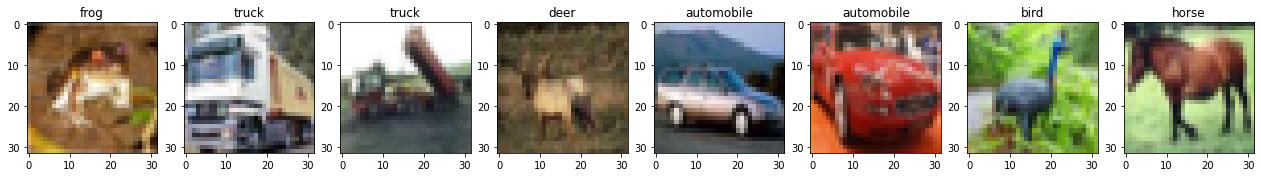

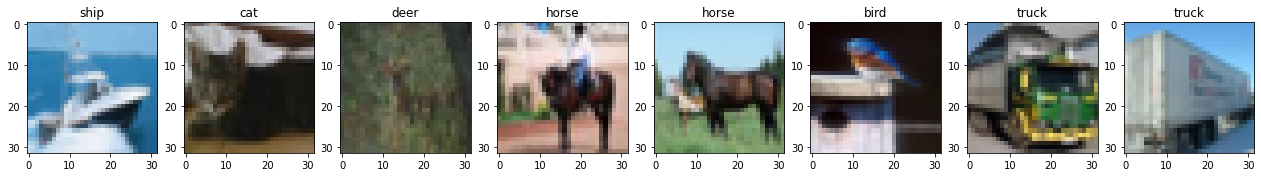

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

# 아래처럼 화질이 낮은 경우는 Augmentation을 가볍게 줘야함.

In [ ]:
tr_images[0]

array([[[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 3.,  3.,  2.],
        [ 3.,  3.,  1.],
        [ 3.,  3.,  1.]],

       [[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 3.,  3.,  2.],
        [ 3.,  3.,  2.],
        [ 3.,  3.,  2.]],

       [[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 3.,  3.,  3.],
        [ 3.,  3.,  4.],
        [ 3.,  3.,  4.]],

       ...,

       [[21., 18., 39.],
        [18., 14., 37.],
        [15., 11., 35.],
        ...,
        [16., 13., 31.],
        [10.,  7., 25.],
        [ 8.,  5., 22.]],

       [[23., 20., 40.],
        [20., 17., 39.],
        [20., 17., 39.],
        ...,
        [25., 23., 40.],
        [21., 18., 37.],
        [19., 16., 35.]],

       [[26., 23., 42.],
        [25., 22., 42.],
        [26., 23., 44.],
        ...,
        [38., 36., 50.],
        [34., 31., 47.],
        [34., 31., 48.]]

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generator 생성
- 원래는 model.fit에 train, label, batch size, shuffle을 넣어줬는데, ImageDataGenerator를 쓰면 여기서 넣어준다.
- 모델에 넣기 위한 데이터 로딩 파트.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    #rotation_range=20,
    #zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    #vertical_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)


flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

### Keras CNN 모델 생성. 

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten 대신 Global AveragePooling 을 적용. 
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [ ]:
model = create_model(verbose=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(type(next(flow_tr_gen)))
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)
print(image_batch[0])

<class 'tuple'>
(64, 32, 32, 3) (64, 10)
[[[0.45098042 0.50980395 0.3921569 ]
  [0.4784314  0.54509807 0.4431373 ]
  [0.36862746 0.4156863  0.32156864]
  ...
  [0.41960788 0.4156863  0.35686275]
  [0.40784317 0.4039216  0.34117648]
  [0.4156863  0.427451   0.34509805]]

 [[0.4666667  0.5019608  0.4039216 ]
  [0.49411768 0.56078434 0.45882356]
  [0.4039216  0.45098042 0.35686275]
  ...
  [0.38823533 0.38431376 0.30980393]
  [0.38823533 0.38823533 0.3137255 ]
  [0.41960788 0.43137258 0.34901962]]

 [[0.4431373  0.48235297 0.38823533]
  [0.5254902  0.57254905 0.4784314 ]
  [0.44705886 0.4666667  0.37647063]
  ...
  [0.38823533 0.3803922  0.3137255 ]
  [0.41176474 0.40784317 0.3254902 ]
  [0.454902   0.44705886 0.36862746]]

 ...

 [[0.6745098  0.6        0.5568628 ]
  [0.5294118  0.5254902  0.45098042]
  [0.6156863  0.64705884 0.5764706 ]
  ...
  [0.43529415 0.4156863  0.3529412 ]
  [0.427451   0.427451   0.3529412 ]
  [0.41176474 0.4039216  0.33333334]]

 [[0.52156866 0.5294118  0.447058

In [ ]:
'''
과거는 아래와 같은 code 였음
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )
'''
# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)), # 생략 가능
                    validation_data=flow_val_gen, 
                    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)), # 생략 가능
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 23s 20ms/step - loss: 1.4498 - accuracy: 0.4735 - val_loss: 1.2973 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 14s 21ms/step - loss: 1.0042 - accuracy: 0.6481 - val_loss: 1.4219 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 16s 24ms/step - loss: 0.8182 - accuracy: 0.7183 - val_loss: 0.9227 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 13s 20ms/step - loss: 0.7009 - accuracy: 0.7632 - val_loss: 0.9241 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 13s 19ms/step - loss: 0.6064 - accuracy: 0.7966 - val_loss: 0.9849 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 13s 19ms/step - loss: 0.5412 - accuracy: 0.8198 - val_loss: 0.7871 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 13s 

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 8ms/step - loss: 0.5826 - accuracy: 0.8915


[0.5825998783111572, 0.8914999961853027]

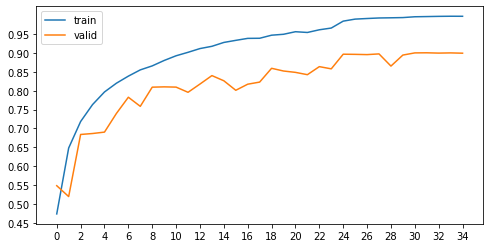

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 40, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 원본 이미지 상황에 맞지 않거나 과도한 Augmentation은 오히려 성능을 저하시킴.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 현재의 데이터는 32 * 32 라서 과할 수 있음.
train_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]

history = model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                    validation_data=flow_val_gen, 
                    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb], verbose=1)


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


665/665 [==============================] - 30s 43ms/step - loss: 1.7736 - accuracy: 0.3368 - val_loss: 2.2289 - val_accuracy: 0.2673 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 40s 60ms/step - loss: 1.4383 - accuracy: 0.4779 - val_loss: 3.6050 - val_accuracy: 0.2735 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 32s 48ms/step - loss: 1.2666 - accuracy: 0.5480 - val_loss: 1.5287 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 29s 43ms/step - loss: 1.1616 - accuracy: 0.5931 - val_loss: 1.2376 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 29s 44ms/step - loss: 1.0698 - accuracy: 0.6247 - val_loss: 1.3129 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 29s 43ms/step - loss: 1.0113 - accuracy: 0.6453 - val_loss: 1.2460 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 29s 43ms/step -

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 7ms/step - loss: 0.5806 - accuracy: 0.8133


[0.5805527567863464, 0.8133000135421753]